### Import packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import pickle
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, log_loss
from keras.applications import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.optimizers import Adam, RMSprop, SGD
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from keras.preprocessing.image import ImageDataGenerator
import json

np.random.seed(2020)
random_state = 52
CATEGORIES = ["c0","c1","c2","c3","c4","c5","c6","c7","c8","c9"]
PATH_COLAB = "/content/drive/My Drive/Deep Learning Project/progetto/"

TensorFlow 1.x selected.


Using TensorFlow backend.


### Definition of functions

In [0]:
def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data

def preprocessing(X, Y, img_rows, img_cols, color_type=3):
    
    Y = np.array(Y, dtype=np.uint8)

    if color_type == 1:
        X = np.array(X, dtype=np.uint8).reshape(-1, img_rows, img_cols, 1)
    else:
        X = np.array(X, dtype=np.uint8).reshape(-1, img_rows, img_cols, 3)

    Y = to_categorical(Y, 10)
    X = X.astype('float32')
    X /= 255
    
    return X, Y

In [0]:
def cnn_scratch(img_rows, img_cols, color_type):

    model = Sequential()

    model.add(Conv2D(filters = 16, padding='same', kernel_size = 3, activation = 'relu', input_shape=(img_rows, img_cols, color_type)))
    model.add(Conv2D(filters = 16, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 32, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(Conv2D(filters = 32, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 64, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(Conv2D(filters = 64, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(Conv2D(filters = 64, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 128, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(Conv2D(filters = 128, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(Conv2D(filters = 128, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Flatten())

    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.3))

    model.add(Dense(64, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(10, activation = 'softmax'))

    model.compile(optimizer = "SGD", loss='categorical_crossentropy', metrics = ["accuracy"])

    print(model.summary())

    return model

In [0]:
def training_model(img_rows, img_cols, color_type=3):
    
    df = pd.DataFrame(columns=['k', 'accuracy', 'log_loss', 'architecture'])
    batch_size = 32
    epochs = 20
    sum_score_acc = 0
    sum_score_log_loss = 0

    name_model = 'cnn_scratch'

    for k in range(1,6):

        print("\n\nFold " + str(k) + ' out of 5')

        X_train, Y_train, X_val, Y_val = restore_data(PATH_COLAB + "data/k_" + str(k) + ".dat")
        X_train, Y_train = preprocessing(X_train, Y_train, img_rows, img_cols, color_type)
        X_val, Y_val = preprocessing(X_val, Y_val, img_rows, img_cols, color_type)

        datagen = ImageDataGenerator(
          height_shift_range=0.5, 
          width_shift_range = 0.5, 
          zoom_range = 0.5, 
          rotation_range=20 
        )

        data_generator = datagen.flow(X_train, Y_train, batch_size = 32)

        model = cnn_scratch(img_rows, img_cols, color_type)

        kfold_weights_path = os.path.join(PATH_COLAB + 'architecture/'+ name_model, 'weights_kfold_' + str(k) + '.h5')

        if not os.path.isfile(kfold_weights_path) or RESTORE_WEIGHTS == False:
            callbacks = [
                EarlyStopping(monitor='val_loss', patience=5, verbose=0),
                ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=0)
            ]
            class_weights = class_weight.compute_sample_weight(class_weight='balanced', y=Y_train)
            
            history = model.fit_generator(data_generator, steps_per_epoch = len(X_train) // batch_size, 
                                epochs=epochs, shuffle=True, verbose=0, validation_data=(X_val, Y_val),
                                class_weight=class_weights, callbacks=callbacks)
            
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

            acc = history.history['acc']
            val_acc = history.history['val_acc']
            n_epoch = range(len(acc))
            axes[0].plot(n_epoch, acc, color='mediumseagreen',marker='.', label='training')
            axes[0].plot(n_epoch, val_acc, color='steelblue', marker='.', label='validation')
            axes[0].set_title('Training and validation accuracy')
            axes[0].set_xlabel('epochs')
            axes[0].set_ylabel('accuracy')
            axes[0].legend(loc="lower right")

            loss = history.history['loss']
            val_loss = history.history['val_loss']
            axes[1].plot(n_epoch, loss, color='mediumseagreen',marker='.', label='training')
            axes[1].plot(n_epoch, val_loss, color='steelblue', marker='.', label='validation')
            axes[1].set_title('Training and validation loss')
            axes[1].set_xlabel('epochs')
            axes[1].set_ylabel('loss')
            axes[1].legend(loc="upper right")

            fig.tight_layout()
            plt.show()
          
        if os.path.isfile(kfold_weights_path):
            model.load_weights(kfold_weights_path)

        predictions_val = model.predict(X_val, batch_size=batch_size, verbose=1)

        predictions_val_arg = [y.argmax() for y in predictions_val]
        Y_val_arg = [y.argmax() for y in Y_val]

        predictions_val_arg = np.array(predictions_val_arg)  
        Y_val_arg = np.array(Y_val_arg)

        score_acc = accuracy_score(Y_val_arg, predictions_val_arg)
        score_log_loss = log_loss(Y_val, predictions_val)
        
        print('Score Accuracy: ', score_acc)
        print('Score Log Loss: ', score_log_loss)

        sum_score_acc += score_acc*X_val.shape[0]
        sum_score_log_loss += score_log_loss*X_val.shape[0]

        print(classification_report(Y_val_arg, predictions_val_arg, target_names=CATEGORIES))

        df = df.append({'k': k, 'accuracy':score_acc, 'log_loss':score_log_loss, 'architecture':name_model}, ignore_index=True)
    
    score_acc = sum_score_acc/(X_train.shape[0] + X_val.shape[0])
    print("Avg Accuracy train indipendent: ", score_acc)

    score_log_loss = sum_score_log_loss/(X_train.shape[0] + X_val.shape[0])
    print("Avg Log Loss train indipendent: ", score_log_loss)

    df['weighted_mean_loss'] = score_log_loss
    df['weighted_mean_acc'] = score_acc

    df.to_csv(PATH_COLAB+'dataframes/'+name_model+'.csv')

    return df



In [0]:
RESTORE_WEIGHTS = False

### CNN_from_scratch



Fold 1 out of 5












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 16)      2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64,

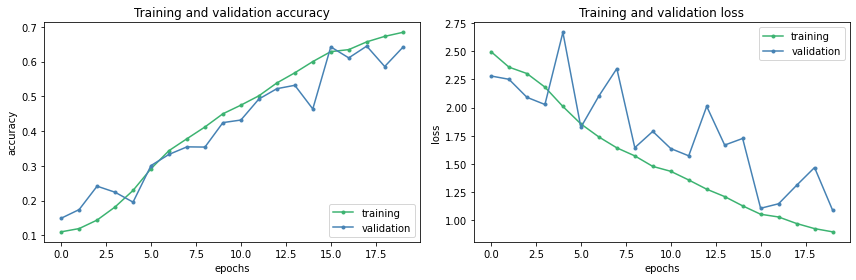

4703/4703 [==============================] - 4s 900us/step
Score Accuracy:  0.6408675313629598
Score Log Loss:  1.08915982484595
              precision    recall  f1-score   support

          c0       0.48      0.55      0.51       455
          c1       0.97      0.61      0.75       466
          c2       0.89      0.69      0.78       515
          c3       0.88      0.91      0.89       487
          c4       0.83      0.59      0.69       500
          c5       0.76      0.92      0.84       498
          c6       0.62      0.54      0.57       483
          c7       0.98      0.36      0.53       425
          c8       0.34      0.46      0.39       416
          c9       0.37      0.72      0.49       458

    accuracy                           0.64      4703
   macro avg       0.71      0.63      0.64      4703
weighted avg       0.72      0.64      0.65      4703



Fold 2 out of 5
Model: "sequential_2"
_________________________________________________________________
Layer 

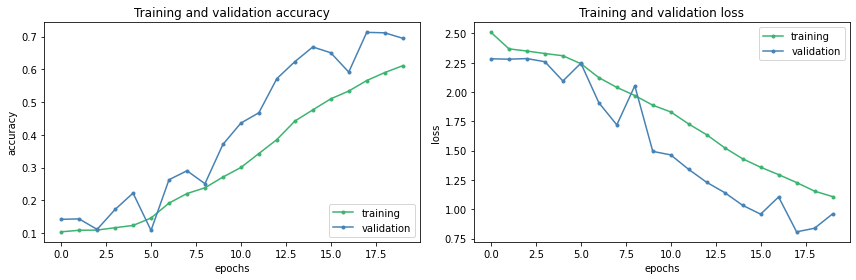

5303/5303 [==============================] - 5s 901us/step
Score Accuracy:  0.7126155006600038
Score Log Loss:  0.8074580672515542
              precision    recall  f1-score   support

          c0       0.55      0.69      0.61       637
          c1       0.89      0.96      0.92       534
          c2       0.96      0.73      0.83       518
          c3       0.76      0.89      0.82       554
          c4       0.48      0.70      0.57       529
          c5       0.87      0.99      0.93       534
          c6       0.76      0.96      0.85       541
          c7       0.66      0.81      0.73       459
          c8       0.69      0.31      0.43       440
          c9       0.49      0.06      0.11       557

    accuracy                           0.71      5303
   macro avg       0.71      0.71      0.68      5303
weighted avg       0.71      0.71      0.68      5303



Fold 3 out of 5
Model: "sequential_3"
_________________________________________________________________
Laye

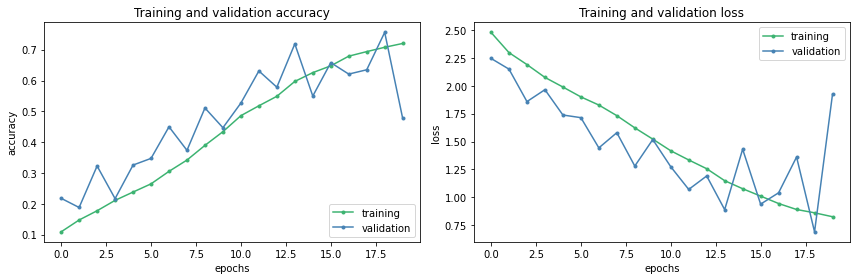

3932/3932 [==============================] - 4s 937us/step
Score Accuracy:  0.7561037639877924
Score Log Loss:  0.6883270530902864
              precision    recall  f1-score   support

          c0       0.69      0.45      0.55       419
          c1       0.79      0.89      0.83       409
          c2       0.79      0.99      0.88       409
          c3       0.74      0.80      0.77       410
          c4       0.98      1.00      0.99       413
          c5       0.99      0.86      0.92       414
          c6       0.89      0.82      0.85       416
          c7       0.73      0.51      0.60       378
          c8       0.51      0.59      0.54       317
          c9       0.46      0.58      0.51       347

    accuracy                           0.76      3932
   macro avg       0.76      0.75      0.74      3932
weighted avg       0.77      0.76      0.75      3932



Fold 4 out of 5
Model: "sequential_4"
_________________________________________________________________
Laye

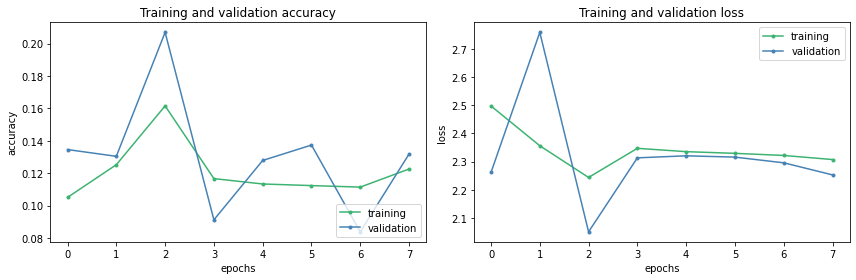

4310/4310 [==============================] - 4s 977us/step
Score Accuracy:  0.20696055684454756
Score Log Loss:  2.050412122694356
              precision    recall  f1-score   support

          c0       0.00      0.00      0.00       501
          c1       0.13      0.03      0.05       408
          c2       0.17      0.58      0.26       429
          c3       0.04      0.01      0.01       459
          c4       1.00      0.01      0.01       437
          c5       0.44      0.77      0.56       452
          c6       0.13      0.33      0.18       435
          c7       1.00      0.00      0.01       402
          c8       0.00      0.00      0.00       376
          c9       0.18      0.32      0.23       411

    accuracy                           0.21      4310
   macro avg       0.31      0.20      0.13      4310
weighted avg       0.30      0.21      0.13      4310



Fold 5 out of 5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 128, 128, 16)      2320      
_________________________________________________________________
batch_normalization_21 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_22 (Batc (None, 64, 64, 32)       

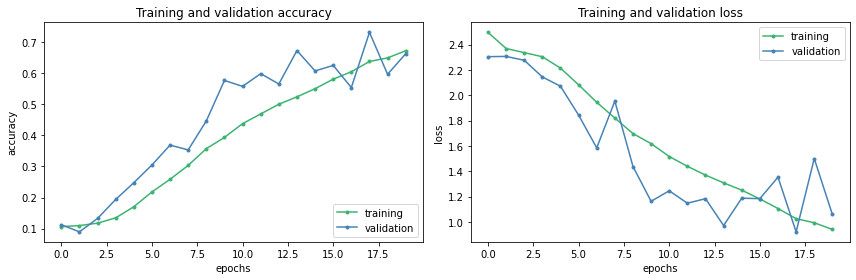

4176/4176 [==============================] - 4s 1ms/step
Score Accuracy:  0.7313218390804598
Score Log Loss:  0.9216555239283237
              precision    recall  f1-score   support

          c0       0.55      0.87      0.67       477
          c1       0.79      0.83      0.81       450
          c2       0.96      0.82      0.88       446
          c3       0.91      0.75      0.82       436
          c4       0.85      0.66      0.74       447
          c5       0.73      0.99      0.84       414
          c6       0.68      0.76      0.72       450
          c7       0.81      0.81      0.81       338
          c8       0.65      0.39      0.49       362
          c9       0.48      0.31      0.38       356

    accuracy                           0.73      4176
   macro avg       0.74      0.72      0.72      4176
weighted avg       0.74      0.73      0.72      4176

Avg Accuracy train indipendent:  0.6114876917588298
Avg Log Loss train indipendent:  1.1058187868522054


,k,accuracy,log_loss,architecture,weighted_mean_loss,weighted_mean_acc
0,1,0.640868,1.089160,cnn_scratch,1.105819,0.611488
1,2,0.712616,0.807458,cnn_scratch,1.105819,0.611488
2,3,0.756104,0.688327,cnn_scratch,1.105819,0.611488
3,4,0.206961,2.050412,cnn_scratch,1.105819,0.611488
4,5,0.731322,0.921656,cnn_scratch,1.105819,0.611488


In [0]:
training_model(128,128,3)